In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Load lattice

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')

env.call('../002_design_optics/matching_constraints.py')

### Select line to match

In [4]:
line = -env['ccs_yl'] + (-env['ccs_xl'])

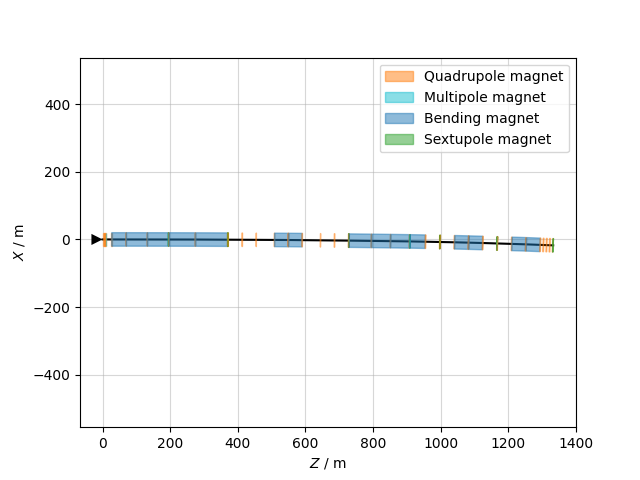

In [5]:
line.survey().plot()

### Load strengths from CCS-Y match

In [6]:
env.vars.load_json('strengths_quads_01_ffccsyl.json')

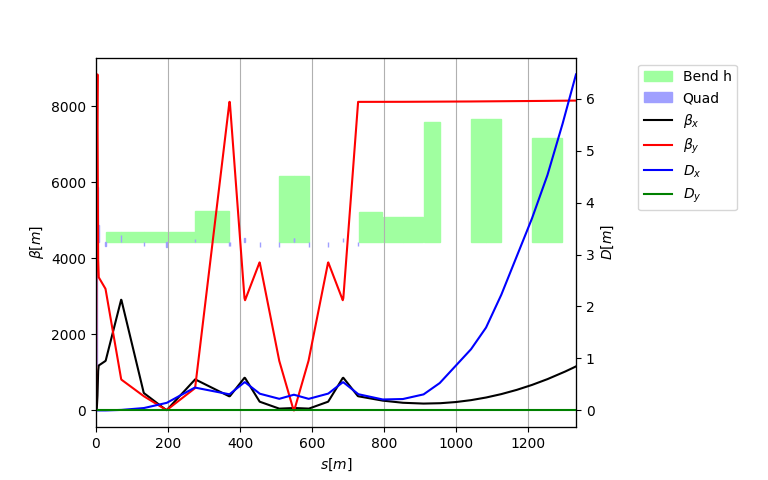

In [7]:
line.twiss(betx=env['bxip'], bety=env['byip']).plot()

### Structure of the lattice

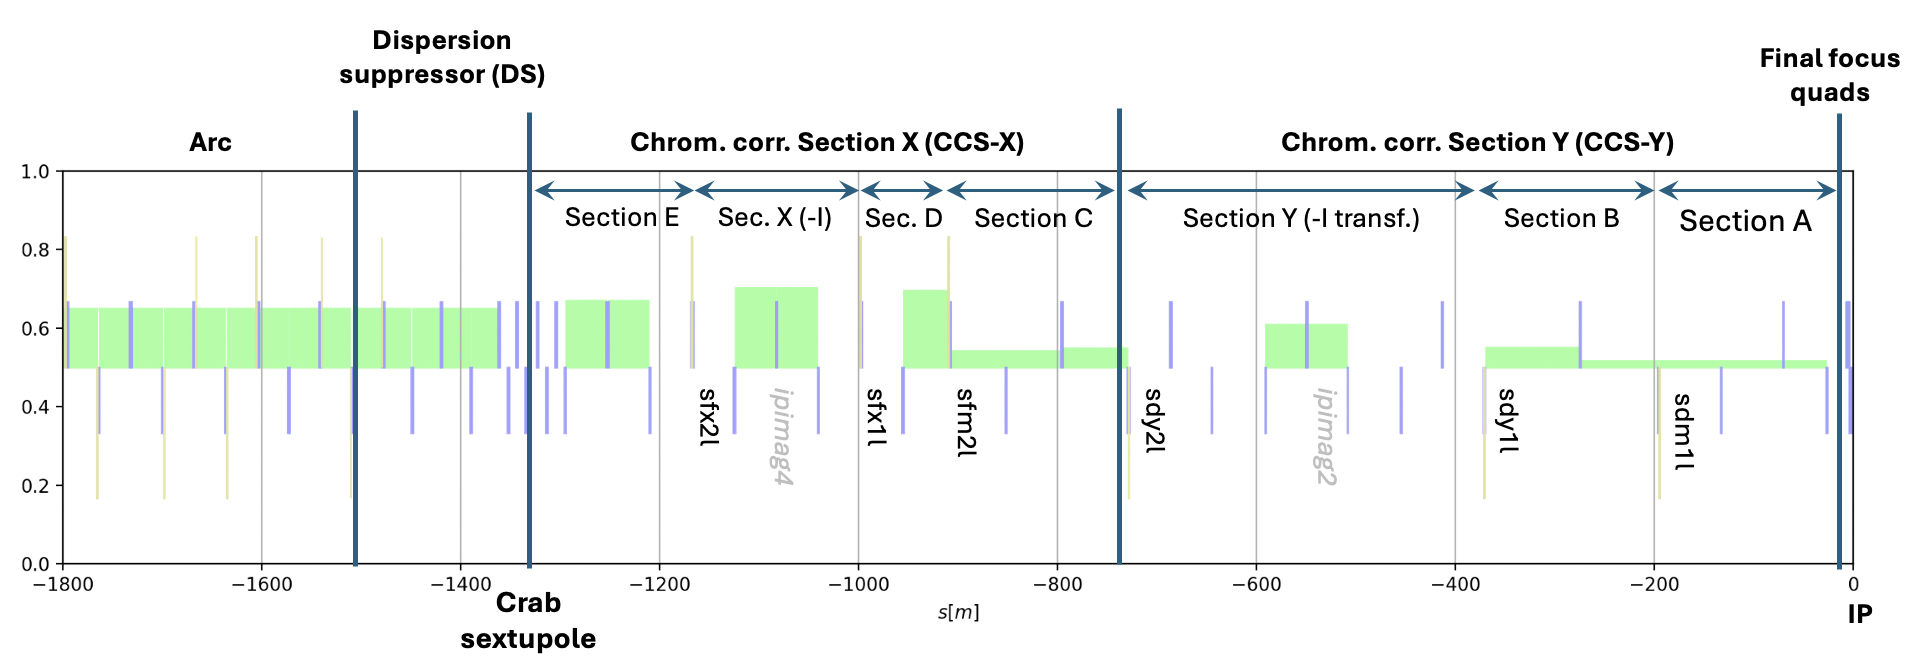

In [8]:
kq_section_c = ['kqd07l', 'kqf08l', 'kqd09l', 'kqf10l']
kq_section_d = ['kqd11l', 'kqf12l']
kq_xquads =    ['kqx00l', 'kqx01l', 'kqx02l']
kq_section_e = ['kqf13l', 'kqd14l', 'kqf15l', 'kqd16l',
                   'kqf17l', 'kqd18l', 'kqf19l', 'kqd20l']

In [9]:
# Initialize quadrupoles with a small strength
for nn in kq_section_c + kq_section_d + kq_xquads + kq_section_e:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

### Match section C

In [10]:
opt_section_c = line.match(
    name='section_c',
    solve=False,
    betx=env['bxip'], bety=env['byip'],
    default_tol=1e-5,
    vary=xt.VaryList(kq_section_c, step=1e-10),
    targets=[
        xt.TargetSet(betx=xt.LessThan(27.0), bety=xt.LessThan(15.0),
                     alfx=xt.GreaterThan(0.), alfy=xt.GreaterThan(0.5),
                     dx=xt.GreaterThan(0.235), at='sfm2l::0'),
        xt.TargetSet(alfy=xt.LessThan(0.9), dx=xt.LessThan(0.25),
                     at='sfm2l::0')])
opt = opt_section_c

In [11]:
# Alternate two optimizers
opt.run_jacobian(20)
opt.run_simplex(1000)

                                             
Optimize [section_c] - start penalty: 7856                         
Matching: model call n. 176 penalty = 2.2546e+02              
Optimize [section_c] - end penalty:  225.465                            
                                             
Optimize [section_c] - start penalty: 225.5                         
Matching: model call n. 301 penalty = 0.0000e+00              
Optimize [section_c] - end penalty:     0                            


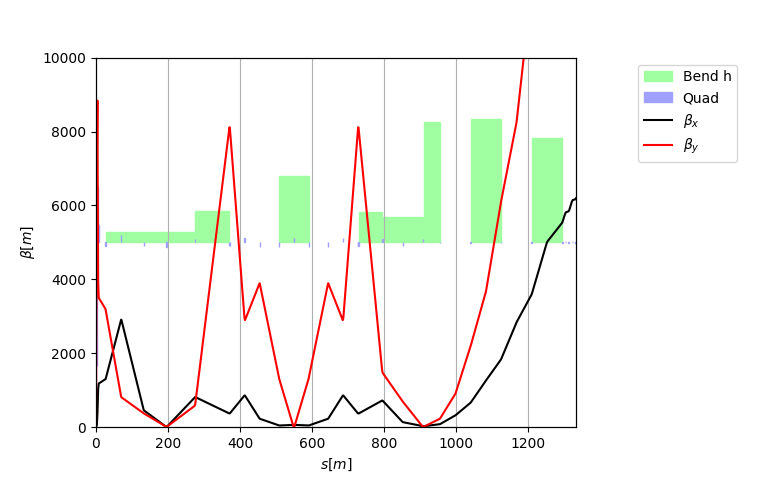

In [12]:
pp=opt.plot('betx bety')
pp.ylim(left_lo=0, left_hi=10000)

### Match section D

In [13]:
opt_section_d = opt_section_c.clone(name='section_d',
          remove_vary=True,
          add_vary=xt.VaryList(kq_section_d, step=1e-10),
          add_targets=xt.TargetSet(betx=xt.GreaterThan(1000.),
             alfx=0,
             bety=xt.LessThan(45.),
             dx=xt.LessThan(0.6),
             mux=1.75 - 0.0093,
             at='sfx1l::1'))
opt = opt_section_d

In [14]:
opt.run_jacobian(20)

                                             
Optimize [section_d] - start penalty: 1096                         
Matching: model call n. 110 penalty = 8.9606e-01              
Optimize [section_d] - end penalty:  0.896059                            


### Match sections C and D together

In [15]:
opt_sections_cd = opt_section_d.clone(
    name='sfx1l_cd',
    add_vary=opt_section_c.vary)
opt = opt_sections_cd

In [16]:
opt.run_jacobian(20)

                                             
Optimize [sfx1l_cd] - start penalty: 0.8961                         
Matching: model call n. 54 penalty = 1.0623e-07              
Optimize [sfx1l_cd] - end penalty:  1.06225e-07                            


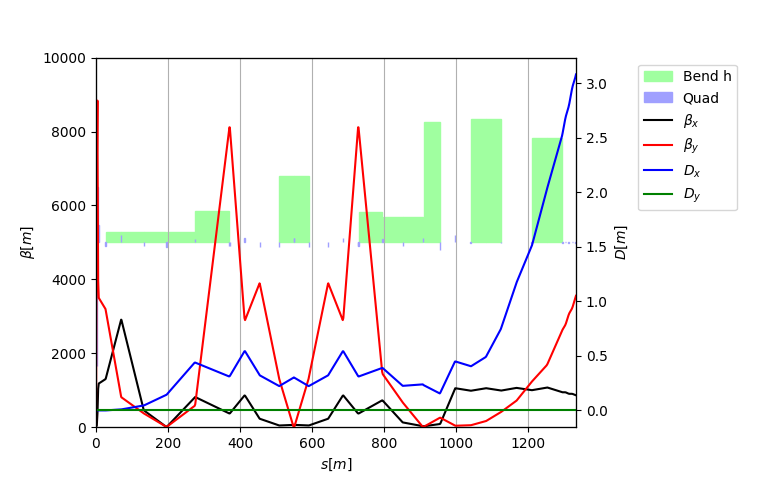

In [17]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000)

#### Match Section X (-I transform.)

In [18]:
# Match r matrix alone
opt_section_x = line.match(
    name='section_x',
    solve=False,
    default_tol=1e-4,
    start='sfx1l::1', end='sfx2l::1',
    init_at='ipimag4',
    betx=0.20, bety=0.20, # Rough estimate
    targets=xt.TargetRmatrix(start='sfx1l::1', end='sfx2l::1',
                r12=env['r12_ccsxl'], r34=env['r34_ccsxl'],
                r11=-1, r33=-1),
    vary=xt.VaryList(kq_xquads, step=1e-10)
)
opt = opt_section_x
opt.targets['r33'].tol = 1e-3

opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

                                             
Optimize [section_x] - start penalty: 1.991                         
Matching: model call n. 46 penalty = 1.1873e-05              
Optimize [section_x] - end penalty:  1.1873e-05                            
                                             
Optimize [section_x] - start penalty: 0.1619                         
Matching: model call n. 67 penalty = 3.4842e-06              
Optimize [section_x] - end penalty:  3.48425e-06                            
                                             
Optimize [section_x] - start penalty: 8.106                         
Matching: model call n. 210 penalty = 8.4002e-02              
Optimize [section_x] - end penalty:  0.084002                            
                                             
Optimize [section_x] - start penalty: 53.93                         
Matching: model call n. 348 penalty = 1.2000e-04              
Optimize [section_x] - end penalty:  0.000120005              

In [19]:
opt.target_status()

Target status:               enalty = 1.2000e-04              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r11   False     0.0001001       -0.9999            -1 r11(sfx1l::1, sfx2l::1, val=-1, tol=0.00 ...
1  ON    r12    True  -5.06537e-08          -0.1          -0.1 r12(sfx1l::1, sfx2l::1, val=-0.1, tol=0. ...
2  ON    r33    True   6.61901e-05     -0.999934            -1 r33(sfx1l::1, sfx2l::1, val=-1, tol=0.00 ...
3  ON    r34    True  -2.96326e-08  -2.96326e-08             0 r34(sfx1l::1, sfx2l::1, val=0.0, tol=0.0 ...


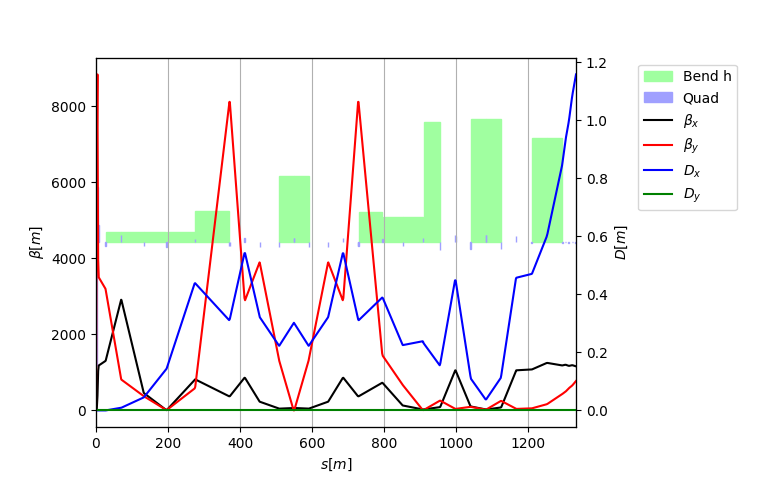

In [20]:
pp = opt_sections_cd.plot()

### Match optics at image point

In [21]:
# Imag 4 without r matrix
opt_imag4 = opt_sections_cd.clone(name='imag4',
                            add_targets=xt.TargetSet(betx=xt.LessThan(20), bety=xt.LessThan(25.),
                                         alfx=0, alfy=env['delta_alfy_ccsx'],
                                         dx=xt.GreaterThan(2e-3),
                                         dpx=env['dpx_ccxl'],
                                         at='ipimag4'))
opt = opt_imag4
opt.step(20)

# Focus on optics at sextupole
opt.disable(target=True)
opt.enable(target='sfx1l.*')
opt.step(200)


                                             
Optimize [imag4] - start penalty: 7.904                         
Matching: model call n. 203 penalty = 3.7615e+00              
Optimize [imag4] - end penalty:  3.76153                            
                                             
Optimize [imag4] - start penalty: 2.914                         
Matching: model call n. 282 penalty = 1.1254e-08              
Optimize [imag4] - end penalty:  1.12536e-08                            


In [22]:
opt_imag4_full = opt_imag4.clone(name='imag4',
            add_vary=opt_section_x.vary,
            add_targets=list(opt_section_x.targets)
)
opt = opt_imag4_full

In [26]:
opt.enable(target=True) # Enable all targets
opt.run_jacobian(20)
opt.run_nelder_mead(1000)

                                             
Optimize [imag4] - start penalty: 132.2                         
Matching: model call n. 1775 penalty = 1.0223e-03              
Optimize [imag4] - end penalty:  0.00102228                            
                                             
Optimize [imag4] - start penalty: 0.001022                         
Matching: model call n. 2883 penalty = 1.0222e-03              
Optimize [imag4] - end penalty:  0.00102217                            


In [27]:
opt.targets['ipimag4_dx'].weight = 10000
opt.targets['ipimag4_dpx'].weight = 1e6
opt.targets['sfx1l::1_mux'].weight = 10000
opt.run_nelder_mead(1000)

                                             
Optimize [imag4] - start penalty: 0.001022                         
Matching: model call n. 3936 penalty = 1.0222e-03              
Optimize [imag4] - end penalty:  0.00102216                            


In [28]:
opt.target_mismatch()

Target mismatch:             penalty = 1.0222e-03              
id state tag         tol_met       residue   current_val target_val         description                                 
4  ON    sfm2l::0_dx   False   -9.9834e-05        0.2349 GreaterThan(0.235) ('dx', 'sfm2l::0'), val=GreaterThan(0.23 ...


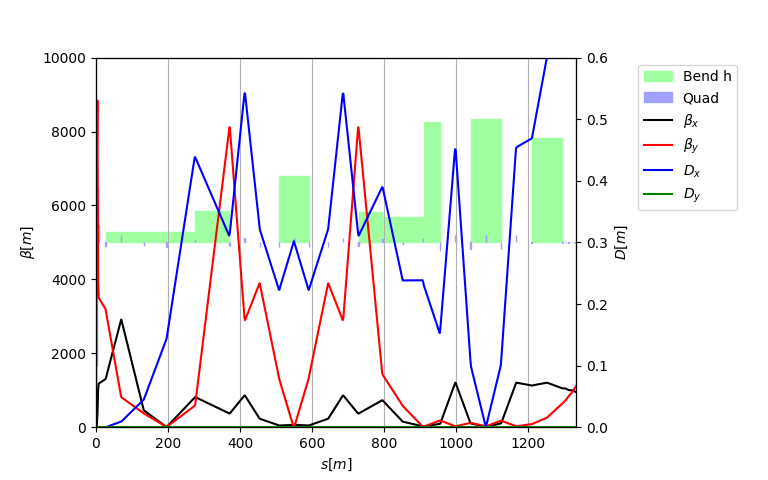

In [29]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000, right_lo=0, right_hi=.6)

### Match optict at end CCS-X section (crab sextupole location)

In [30]:
# Try to close with downstream quadrupoles alone
opt_end = opt_imag4.clone(
    name='end',
    remove_vary=True,
    remove_targets=True,
    add_vary=xt.VaryList(kq_section_e, step=1e-10),
    add_targets=[xt.TargetSet(
                       betx=env['bx_ff_out'], alfx=0.0,
                       bety=env['by_ff_out'], alfy = 0.0,
                       dx=env['dx_ff_out'], dpx=0.0,
                       mux=3.0, muy=2.75, at=xt.END),
                 xt.TargetSet(dx=0, dpx=0, at='qf17l'), # to prevent dx going wild in the straight
                 xt.TargetSet(dx=0, dpx=0, at='qd18l'), # to prevent dx going wild in the straight
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf17l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd18l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf19l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd20l'),
                 xt.TargetSet(bety=xt.GreaterThan(750), at='qf19l'),
    ]
)
opt = opt_end

In [31]:
opt.run_jacobian(10)

                                             
Optimize [end] - start penalty: 1016                         
Matching: model call n. 126 penalty = 5.3785e+02              
Optimize [end] - end penalty:  537.849                            


In [32]:
opt.targets['END_dx'].weight = 100
opt.targets['END_dpx'].weight = 100

In [33]:
opt.run_jacobian(20)
opt.run_simplex(10000)

                                             
Optimize [end] - start penalty: 537.9                         
Matching: model call n. 385 penalty = 2.8784e+01              
Optimize [end] - end penalty:  28.7836                            
                                             
Optimize [end] - start penalty: 28.78                         
Matching: model call n. 10618 penalty = 4.5554e-01              
Optimize [end] - end penalty:  0.455541                            


In [ ]:
#### All targets and knobs together

In [34]:
opt_full = opt_end.clone(
    name='full',
    add_targets=opt_imag4_full.targets,
    add_vary=opt_imag4_full.vary
)
opt=opt_full

In [35]:
# Configure weights
opt.targets['END_mux'].weight = 10000
opt.targets['END_muy'].weight = 10000
opt.targets['END_dpx'].weight = 10000
opt.targets['ipimag4_alfx'].weight = 10000
opt.targets['ipimag4_alfy'].weight = 10000
opt.targets['r33'].weight = 100
opt.targets['r34'].weight = 100

In [36]:
opt.target_status()

Target status:               alty = 4.5426e+02              
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx        False   -0.00471288       66.6623 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety        False  -4.93756e-05          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx        False  -0.000900734  -0.000900734 0.0                ('alfx', '_end_point'), val=0, tol=1e-05 ...
3  ON    END_alfy        False  -3.86633e-05  -3.86633e-05 0.0                ('alfy', '_end_point'), val=0, tol=1e-05 ...
4  ON    END_mux         False      0.022481       3.02248 3.0                ('mux', '_end_point'), val=3, tol=1e-05, ...
5  ON    END_muy         False     0.0394736       2.78947 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx          False  -0.000298616  -0.000298616 0.0                

In [38]:
opt.run_jacobian(50)

                                             
Optimize [full] - start penalty: 454.3                         
Matching: model call n. 78 penalty = 2.1749e-02              
Optimize [full] - end penalty:  0.0217493                            


In [39]:
opt.target_status()


Target status:               nalty = 2.1749e-02              
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx         True  -5.84399e-08        66.667 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety         True  -1.16137e-06          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx         True   1.29434e-09   1.29434e-09 0.0                ('alfx', '_end_point'), val=0, tol=1e-05 ...
3  ON    END_alfy         True   3.58424e-09   3.58424e-09 0.0                ('alfy', '_end_point'), val=0, tol=1e-05 ...
4  ON    END_mux          True   8.59357e-12             3 3.0                ('mux', '_end_point'), val=3, tol=1e-05, ...
5  ON    END_muy          True   4.44089e-16          2.75 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx           True  -1.83303e-10  -1.83303e-10 0.0               

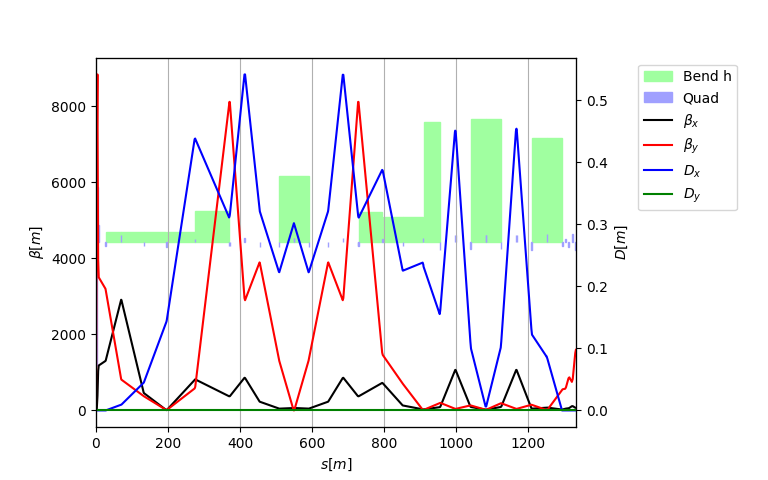

In [40]:
opt.plot()

### Extract and save quadrupole strengths

In [43]:
strengths = opt.get_knob_values()
xt.json.dump(strengths, 'strengths_quads_02_ffccsxl.json')